In [88]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
bene_train = pd.read_csv('./data/Train_Beneficiary.csv')
inpat_train = pd.read_csv('./data/Train_Inpatient.csv')
outpat_train = pd.read_csv('./data/Train_Outpatient.csv')
target_train = pd.read_csv('./data/Train.csv')

print(bene.shape)
print(inpat.shape)
print(outpat.shape)
print(target.shape)

bene_test = pd.read_csv('./data/Test_Beneficiary.csv')
inpat_test = pd.read_csv('./data/Test_Inpatient.csv')
outpat_test = pd.read_csv('./data/Test_Outpatient.csv')
target_test = pd.read_csv('./data/Test.csv')

print(bene_test.shape)
print(inpat_test.shape)
print(outpat_test.shape)
print(target_test.shape)

(202524, 26)
(50025, 31)
(643578, 28)
(6763, 3)
(63968, 25)
(9551, 30)
(125841, 27)
(1353, 1)


In [147]:
bene_train['Set'] = 'Train'
inpat_train['Set'] = 'Train'
outpat_train['Set'] = 'Train'
target_train['Set'] = 'Train'

bene_test['Set'] = 'Test'
inpat_test['Set'] = 'Test'
outpat_test['Set'] = 'Test'
target_test['Set'] = 'Test'

In [178]:
bene = pd.concat([bene_train,bene_test]).reset_index(drop=True)
inpat = pd.concat([inpat_train,inpat_test]).reset_index(drop=True)
outpat = pd.concat([outpat_train,outpat_test]).reset_index(drop=True)
target = pd.concat([target_train,target_test]).reset_index(drop=True)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [179]:
bene = bene.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 0)
bene = bene.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

In [180]:
bene.rename(columns = {"ChronicCond_Alzheimer":"Alzheimer",
             "ChronicCond_Heartfailure":"HeartFailure",
             "ChronicCond_KidneyDisease":"KidneyDisease",
             "ChronicCond_Diabetes":"Diabetes",
             "ChronicCond_IschemicHeart":"IschemicHeart",
             "ChronicCond_Osteoporasis":"Osteoporasis",
             "ChronicCond_rheumatoidarthritis":"RheumatoidArthritis",
             "ChronicCond_stroke":"Stroke",
             "ChronicCond_Cancer":"Cancer",
             "ChronicCond_ObstrPulmonary":"ObstrPulmonary",
             "ChronicCond_Depression":"Depression"}, inplace=True)

In [181]:
bene.sample(4)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,Diabetes,IschemicHeart,Osteoporasis,RheumatoidArthritis,Stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Set
156938,BENE53505,1929-10-01,NaN,1,1,1,18,550,12,12,...,1,1,1,1,1,29000,3204,4010,460,Test
190946,BENE132402,1923-07-01,NaN,0,1,0,16,680,12,12,...,1,0,0,0,0,0,0,150,70,Test
169070,BENE81748,1923-05-01,NaN,1,3,0,5,200,12,12,...,1,1,0,1,0,9000,2136,4940,210,Test
50465,BENE65052,1927-08-01,NaN,1,1,0,49,520,12,12,...,1,1,1,0,1,0,0,770,270,Train


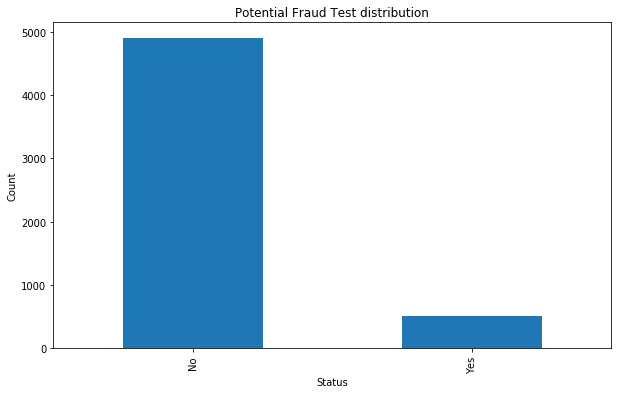

In [182]:
plt.title("Potential Fraud Test distribution")
target.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

Change label to binary for fraud target

In [183]:
target.fillna('?',inplace=True)

In [184]:
#target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 


Add Features to flag if patient is dead


In [185]:
bene['WhetherDead']= 0
bene.loc[bene.DOD.notna(),'WhetherDead'] = 1

Create Flag Before merge to track whats inpatient and whats outpatient

In [186]:
inpat['Status'] = 'in'
outpat['Status'] = 'out'

Combine inpatient and outpatient data

In [187]:
mediCare = pd.merge(inpat, outpat, left_on = [ x for x in outpat.columns if x in inpat.columns], right_on = [ x for x in outpat.columns if x in inpat.columns], how = 'outer')
mediCare.shape

(693603, 32)

Combine with beneficiary. (Outer join to preserve all records)

In [188]:
data = pd.merge(mediCare, bene,left_on=['BeneID','Set'],right_on=['BeneID','Set'], how='inner')
data.shape

(693603, 57)

In [189]:
data.sample(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,Diabetes,IschemicHeart,Osteoporasis,RheumatoidArthritis,Stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead
519658,BENE137058,CLM127946,2009-01-09,2009-01-09,PRV52347,500,PHY419682,PHY419682,PHY407738,NaN,...,1,1,0,0,1,0,0,2000,710,0
344664,BENE71025,CLM512020,2009-08-07,2009-08-07,PRV54966,80,PHY334905,NaN,NaN,NaN,...,1,0,0,1,0,0,0,1930,1350,0
539805,BENE144635,CLM546971,2009-08-26,2009-09-03,PRV54723,60,PHY327549,NaN,PHY327549,NaN,...,1,1,0,0,0,0,0,440,170,0


Count number of Procedures in the claim


In [190]:
ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]

In [191]:
data['NumProc'] = data[ClmProcedure_vars].notnull().to_numpy().sum(axis = 1)

In [192]:
np.unique(data.NumProc.values)

array([0, 1, 2, 3, 4, 5])

Count number of diagnoses per claim

In [193]:
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
    
### Create new variable 
data['NumClaims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)


In [194]:
np.unique(data.NumClaims.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [195]:
from datetime import datetime

In [196]:
data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')

data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')

data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')

### Number of hospitalization days
data['AdmissionDays'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1
### Number of claim days 
data['ClaimDays'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1

data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)

In [197]:
# for i in np.unique(data.State):
#     state_data = data[data.State==i]
#     filename = "./plots/state_level/age-claim/state_{}.png".format(i)
#     print(filename)
#     plt.figure()
#     ax = sns.scatterplot(x='Age',y='InscClaimAmtReimbursed', hue = 'Status', data=state_data);
#     ax.figure.savefig(filename,bbox_inches='tight');
#     plt.close()



In [198]:
# sns.scatterplot(x='InscClaimAmtReimbursed',
#                 y='DeductibleAmtPaid',
#                 hue='Status',
#                 data=data)

In [203]:
data.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Set', 'Status', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'Alzheimer', 'HeartFailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'RheumatoidArthritis', 'Stro

In [205]:
chronicConds = data[['Alzheimer', 'HeartFailure', 'KidneyDisease',
       'Cancer', 'ObstrPulmonary', 'Depression', 'Diabetes', 'IschemicHeart',
       'Osteoporasis', 'RheumatoidArthritis', 'Stroke']]

np.unique(chronicConds.values.flatten()) # Checks out

array([0, 1])

In [206]:
### Create new variable 
data['NumChronics'] = chronicConds.sum(axis = 1)

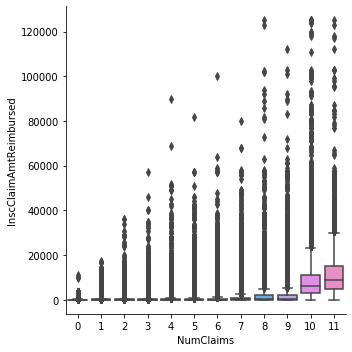

In [171]:
sns.catplot(y='InscClaimAmtReimbursed',
                x='NumClaims',
                #hue='Race',
            kind='box',
                data=data)

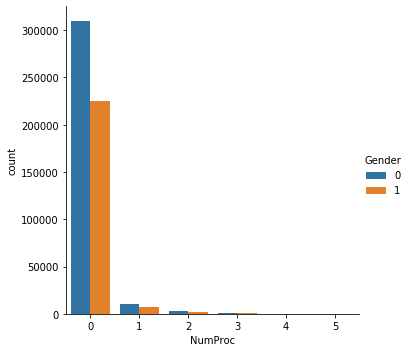

In [72]:
sns.catplot(#y='InscClaimAmtReimbursed',
                x='NumProc',
                hue='Gender',
            kind='count',
                data=data)

In [68]:
data.groupby(['NumProc','NumClaims'])[['InscClaimAmtReimbursed','DeductibleAmtPaid']].median().reset_index()

,NumProc,NumClaims,InscClaimAmtReimbursed,DeductibleAmtPaid
0,0,0,60,0.0
1,0,1,70,0.0
2,0,2,70,0.0
3,0,3,80,0.0
4,0,4,80,0.0
5,0,5,90,0.0
6,0,6,100,0.0
7,0,7,100,0.0
8,0,8,200,0.0
9,0,9,200,0.0


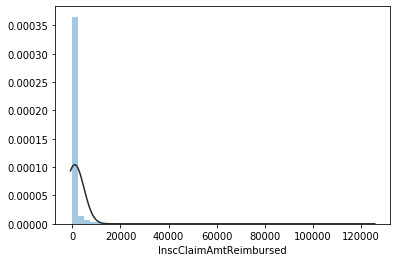

In [30]:
from scipy.stats import norm
ax = sns.distplot(a=data.InscClaimAmtReimbursed, fit=norm, kde=False);

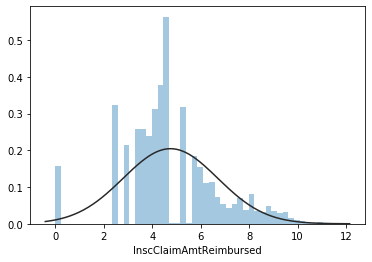

In [92]:
ax = sns.distplot(a=np.log(data.InscClaimAmtReimbursed+1), fit=norm, kde=False);


These are all the deductible amounts that people pay. 

In [59]:
np.unique(data.DeductibleAmtPaid.values)

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  200.,  865.,  876.,  886.,  897., 1068.])

In [ ]:
# for i in np.unique(data.State):
#     state_data = data[data.State==i]
#     filename = "./plots/state_level/age-claim/state_{}.png".format(i)
#     print(filename)
#     plt.figure()
#     ax = sns.scatterplot(x='Age',y='InscClaimAmtReimbursed', hue = 'Status', data=state_data);
#     ax.figure.savefig(filename,bbox_inches='tight');
#     plt.close()


In [219]:
data.to_csv('./data/combinedDesign.csv')
target.to_csv('./data/combinedTarget.csv')

## Aiko Questions

### Set 1

1. How many medical doctors are there in the train outpatient dataset?

In [136]:
train_docs = data[data.Set=='Train']

np.unique(train_docs[data.Status=='out'][['AttendingPhysician','OperatingPhysician','OtherPhysician']].fillna('').values.flatten()).shape

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(89771,)

2. How many medical doctors are there in the train inpatient dataset? Do they match with those from the outpatient record?

In [137]:
np.unique(train_docs[data.Status=='in'][['AttendingPhysician','OperatingPhysician','OtherPhysician']].fillna('').values.flatten()).shape

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(18257,)

3. Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients, or do those who have more visits to the providers have worse health conditions? Provide an analysis on these issues.

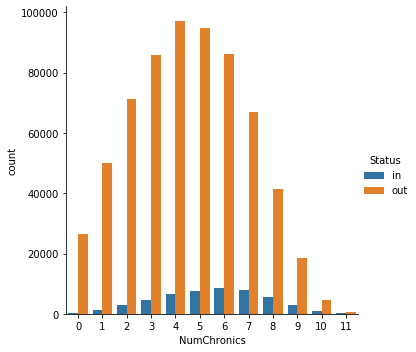

In [217]:
inpat = data[data.Status=='in']
outpat = data[data.Status=='out']

ax = sns.catplot(x="NumChronics", hue='Status', kind='count', data=data)

4. How many distinct patients (BeneIDs) are there in the in/out-patient datasets?

5. Do doctors serve for different providers? Study the distribution of hospital counts/doctor? Is it possible to characterize those doctors who move around among different providers?

6. Do patients go to different hospitals? Study the distribution of hospital counts/patient? It is possible to characterize those patients who receive services from a lot of different hospitals?

7. Do the same providers provide both inpatient and outpatient services? Summarize your finding.

8. Do Some of the same patients receive both inpatient and outpatient services? Summarize your finding.